In [1]:
# Cleaner version of the code from http://gorayni.blogspot.com/2014/06/boltzmann-machines.html

# from __future__ import division
from enum import Enum
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [2]:
Clamp = Enum('Clamp', 'VISIBLE_UNITS NONE INPUT_UNITS')

class Step:
    def __init__(self, temperature, epochs):
        self.temperature = temperature
        self.epochs = epochs
        

annealing_schedule = [Step(20.,2), Step(15.,2), Step(12.,2), Step(10.,4)]

co_occurrence_cycle = Step(10., 10)

patterns = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

In [3]:
mnist = fetch_openml('mnist_784')

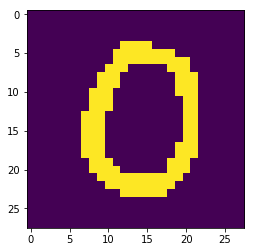

[1. 0.]


In [4]:
data = mnist.get('data') > 64
ts = mnist.get('target').astype(int)

pts = np.where(ts < 2)
data = data[pts]
ts = ts[pts]

target = np.zeros((len(data), 2))
target[np.arange(len(data)), ts] = 1


z = np.random.randint(len(data))
plt.imshow(data[z].reshape(28, -1))
plt.show()
print(target[z])

In [14]:
class Model:
    def __init__(self, inp, out, hidden, schedule, coc, sleep=True):
        self.input_size = inp
        self.output_size = out
        self.hidden_size = hidden
        self.N = inp + out + hidden
        self.vis_size = inp + out
        self.sleep = sleep
        self.schedule = schedule
        
        self.cooccurrence_cycle = coc

        self.weights = np.zeros((self.N, self.N))
        self.states = np.zeros(self.N, dtype=np.int)

        connections = np.triu(np.ones((self.N,) * 2, dtype=np.int), k=1)
        connections[:self.input_size, self.input_size:self.vis_size] = 0

        valid = np.nonzero(connections)
        self.num_connections = np.size(valid[0])
        connections[valid] = np.arange(1, self.num_connections + 1)
        self.connections = connections + connections.T - 1

    def propagate(self, temperature, clamp):
        num_units = self.N
        if clamp == Clamp.VISIBLE_UNITS:
            num_units -= self.vis_size 
        elif clamp == Clamp.INPUT_UNITS:
            num_units -= self.input_size
        units = self.N - np.random.randint(num_units, size=num_units) - 1
        for unit in units:
            p = expit(self.weights[unit, :] @ self.states / temperature)
            self.states[unit] = int(np.random.uniform() <= p)

    def anneal(self, clamp):
        for step in self.schedule:
            for epoch in range(step.epochs):
                self.propagate(step.temperature, clamp)     

    def sum_co_occurrence(self, clamp):
        self.anneal(clamp)
        sums = np.zeros(self.num_connections)
        for epoch in range(self.cooccurrence_cycle.epochs):
            self.propagate(self.cooccurrence_cycle.temperature, clamp)
            valid = np.nonzero(np.outer(self.states, self.states) & (np.triu(self.connections + 1) > 0))
            sums[self.connections[valid]] += 1
        return sums / self.cooccurrence_cycle.epochs

    def recall(self, pattern):
        # Setting pattern to recall and random hidden/output
        self.states[:self.input_size] = pattern
        self.states[self.input_size:] = np.random.randint(2, size=self.hidden_size + self.output_size)
        self.anneal(Clamp.INPUT_UNITS)
        return self.states[self.input_size:self.vis_size] 

    def add_noise(self, pattern):
        probabilities = 0.85 * pattern + 0.05
        uniform = np.random.random(self.vis_size)    
        return (uniform < probabilities).astype(int)

    def learn(self, patterns, targets, epochs=30, batch_size=10, evaluate=False):
        accuracies = []
        for i in range(epochs):
            print(f'epoch {i}')
            if (i + 1) % 5 == 0:
                accuracies.append(self.evaluate(patterns, targets, n=2000))
            idx = np.random.randint(len(patterns), size=batch_size)
            # Positive phase
            pplus = np.zeros(self.num_connections)
            for j, (pattern, target) in enumerate(zip(patterns[idx], targets[idx])):
                # Setting visible units values (inputs and outputs)
                self.states[:self.input_size] = pattern
                self.states[self.input_size:self.vis_size] = target
                
                # Assigning random values to the hidden units
                self.states[self.vis_size:] = np.random.randint(2, size=self.hidden_size)
                pplus += self.sum_co_occurrence(Clamp.VISIBLE_UNITS)
            pplus /= batch_size
            
            # Negative phase
            self.states = np.random.randint(2, size=self.N)
            pminus = self.sum_co_occurrence(Clamp.NONE)
            if not self.sleep:
                pminus = 0.25 * np.ones(pminus.shape)
                
            to_update = np.nonzero(np.triu(self.connections + 1) > 0)
            indices = self.connections[to_update]
            self.weights[to_update] += 2 * np.sign(pplus[indices] - pminus[indices])
            self.weights[to_update[::-1]] = self.weights[to_update]
        return accuracies
            
    def evaluate(self, patterns, targets, n=1000):
        idx = np.random.randint(len(patterns), size=n)
        correct = sum((self.recall(p) == t).all() for p, t in zip(patterns[idx], targets[idx]))
        return correct / n

In [15]:
with_sleep = Model(784, 2, 128, annealing_schedule, co_occurrence_cycle)
no_sleep = Model(784, 2, 128, annealing_schedule, co_occurrence_cycle, sleep=False)

In [16]:
sleep_acc = with_sleep.learn(data, target, epochs=40)
nosleep_acc = no_sleep.learn(data, target, epochs=40)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39


In [18]:
print(with_sleep.evaluate(data, target, n=5000))
print(no_sleep.evaluate(data, target, n=5000))

0.5476
0.001


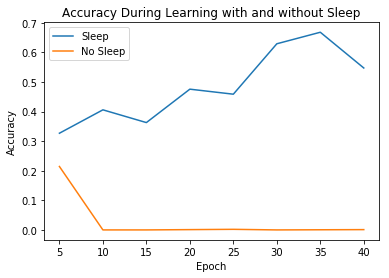

In [39]:
plt.plot(5 + 5 * np.arange(len(sleep_acc)), sleep_acc, label='Sleep')
plt.plot(5 + 5 * np.arange(len(sleep_acc)), nosleep_acc, label='No Sleep')
plt.legend(loc='best')
plt.title('Accuracy During Learning with and without Sleep')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

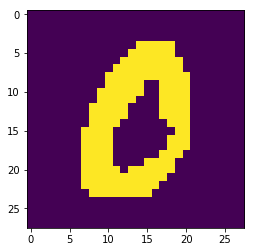

In [27]:
plt.imshow(data[25].reshape(-1, 28))

In [24]:
no_sleep.recall(data[10])

array([1, 1])

In [28]:
idx = np.random.randint(len(data), size=100)
print([no_sleep.recall(data[i]) for i in idx])

[array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1, 1]), array([1,

In [53]:
print(no_sleep.weights.mean())

-74.64682617584954


In [47]:
print(914 ** 2)

835396
